In [1]:
#import all the libraries required
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import cv2

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#split the dataset into train , test and validation datasets
import os
import shutil
from sklearn.model_selection import train_test_split

original_dataset_dir = '/content/drive/MyDrive/subfolder-10'
base_dir = '/content/drive/MyDrive/alternative'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create new directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split data
def split_data(original_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15):
    classes = ['add', 'non-add']
    for cls in classes:
        cls_dir = os.path.join(original_dir, cls)
        images = os.listdir(cls_dir)

        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=val_ratio / (1 - train_ratio), random_state=42)

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))

        for img in val_images:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))

        for img in test_images:
            shutil.copy(os.path.join(cls_dir, img), os.path.join(test_dir, cls, img))

# Split the data
split_data(original_dataset_dir, train_dir, val_dir, test_dir)

In [6]:
train_dir = '/content/drive/MyDrive/alternative/train'
val_dir = '/content/drive/MyDrive/alternative/val'
test_dir = '/content/drive/MyDrive/alternative/test'

In [7]:
#preprocessing the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1215 images belonging to 2 classes.
Found 261 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


In [9]:
!pip install pytesseract
!apt-get update
!apt-get install -y tesseract-ocr

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,125 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,375 kB]
Fetched 3,841 kB in 3s (1,257 kB/s)
Reading package li

In [10]:
#feature extraction
import numpy as np
import os
import cv2
import pytesseract
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to detect text overlays
def detect_text(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray)
    return text

# Function to detect products
def detect_products(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

# Function to analyze color scheme
def analyze_color_scheme(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to preprocess images and extract features
def preprocess_images_and_extract_features(directory):
    images = []
    labels = []

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                if os.path.isfile(file_path):
                    image = cv2.imread(file_path)
                    if image is None:
                        continue

                    image = cv2.resize(image, (224, 224))  # Resize image to (224, 224)
                    image = preprocess_input(image)  # Preprocess image for ResNet50

                    images.append(image)

                    if subdir == 'add':
                        labels.append(1)  # Ad creative
                    else:
                        labels.append(0)  # Non-ad creative

    if not images:
        print("Error: No images found.")
        return None, None

    return np.array(images), np.array(labels)

# Preprocess images and extract features from train, validation, and test directories
train_dir = '/content/drive/MyDrive/alternative/train'
test_dir = '/content/drive/MyDrive/alternative/test'
val_dir = '/content/drive/MyDrive/alternative/val'
X_train, y_train = preprocess_images_and_extract_features(train_dir)
X_val, y_val = preprocess_images_and_extract_features(val_dir)
X_test, y_test = preprocess_images_and_extract_features(test_dir)

# Check the shapes of the resulting feature arrays
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (1215, 224, 224, 3), y_train shape: (1215,)
X_val shape: (261, 224, 224, 3), y_val shape: (261,)
X_test shape: (262, 224, 224, 3), y_test shape: (262,)


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Load ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])



In [17]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Epoch 1/5
38/38 [==============================] - 332s 9s/step - loss: 0.3456 - accuracy: 0.8617 - val_loss: 0.5520 - val_accuracy: 0.7854 - lr: 2.0000e-05
Epoch 2/5
38/38 [==============================] - 303s 8s/step - loss: 0.3124 - accuracy: 0.8667 - val_loss: 0.5514 - val_accuracy: 0.7893 - lr: 2.0000e-05
Epoch 3/5
38/38 [==============================] - 330s 9s/step - loss: 0.3181 - accuracy: 0.8650 - val_loss: 0.5520 - val_accuracy: 0.7778 - lr: 2.0000e-05
Epoch 4/5
38/38 [==============================] - 301s 8s/step - loss: 0.3112 - accuracy: 0.8774 - val_loss: 0.5516 - val_accuracy: 0.7854 - lr: 2.0000e-05
Epoch 5/5
38/38 [==============================] - 329s 9s/step - loss: 0.2833 - accuracy: 0.8938 - val_loss: 0.5554 - val_accuracy: 0.7854 - lr: 2.0000e-05


In [19]:
#test model with an image of test dataset
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load the best saved model
model = load_model('best_model.h5')

# Function to preprocess a single image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read the image.")
        return None

    # Resize the image to the target size (224, 224)
    image = cv2.resize(image, (224, 224))

    # Convert image from BGR to RGB (as OpenCV loads images in BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Rescale the image values to the range [0, 1]
    image = image / 255.0

    # Expand dimensions to match the input shape expected by the model
    image = np.expand_dims(image, axis=0)

    return image

# Function to predict whether an image is a creative ad or not
def predict_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    if preprocessed_image is None:
        return None

    # Make predictions
    prediction = model.predict(preprocessed_image)

    # Interpret the prediction: threshold of 0.5 for binary classification
    is_creative_ad = int(prediction[0] > 0.5)

    return is_creative_ad

# Test the model on a single image
image_path = '/content/drive/MyDrive/alternative/test/non-add/20886.png'
is_creative_ad = predict_image(image_path)

if is_creative_ad:
    print("The image is classified as a creative ad (1).")
else:
    print("The image is not classified as a creative ad (0).")


1/1 [==============================] - 2s 2s/step
The image is not classified as a creative ad (0).


<ipython-input-19-dae6e2ecab28>:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  is_creative_ad = int(prediction[0] > 0.5)


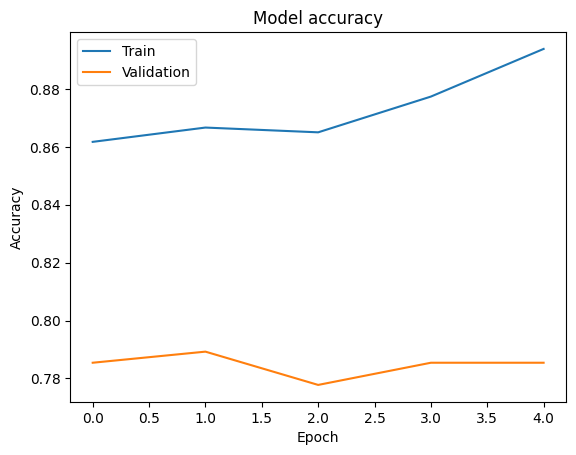

In [22]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


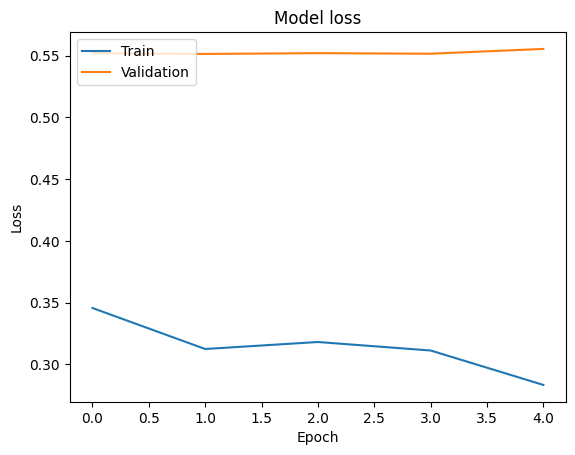

In [24]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()